This notebook performs the analysis of applying the FCC filters over the curr_ping data of jan'2022. To run the same analysis for a different month's data change the declaration of the data variable in the 4th cell.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
import redis

In [ ]:
from google.colab import drive
drive.mount('/content/drive/') 
%cd /content/drive/MyDrive/Broadband_Measurement_Clearhouse

In [2]:
data = pd.read_csv("../202201/curr_ping.csv")

In [3]:
data.describe()

,unit_id,rtt_avg,rtt_min,rtt_max,rtt_std,successes,failures
count,5.039076e+06,5.039076e+06,5.039076e+06,5.039076e+06,5.039076e+06,5.039076e+06,5.039076e+06
mean,1.814625e+07,3.026319e+04,2.631678e+04,3.668559e+04,4.555062e+03,4.967255e+00,3.274489e-02
std,1.968837e+07,7.373690e+04,5.701323e+04,1.089233e+05,3.630743e+04,2.260655e-01,2.260655e-01
min,2.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.971940e+05,1.189800e+04,1.056400e+04,1.340500e+04,3.460000e+02,5.000000e+00,0.000000e+00
50%,3.942037e+06,1.832200e+04,1.654200e+04,2.076100e+04,7.550000e+02,5.000000e+00,0.000000e+00
75%,3.851335e+07,3.016900e+04,2.802800e+04,3.312300e+04,1.910000e+03,5.000000e+00,0.000000e+00
max,5.864553e+07,9.410836e+06,8.374985e+06,1.076507e+07,7.016315e+06,5.000000e+00,5.000000e+00


# List of filters applied
- Filter 1: check for 0 and empty values for all the columns
- Filter 2 (FCC): remove test instances where the range of a unit’s of individual round trip times exceeded 300ms. Formula: $$rtt\_max - rtt\_min > 300000$$
- Filter 3 (FCC): remove test instances where any round trip time was reported as 0.05ms or lower. Formula: $$rtt\_min < 50$$ 
- Filter 4 (FCC): remove test instances with less than 50 successful packets. Formula: $$successes< 50$$ 
- Filter 5 (FCC): remove test instances where packet loss exceeded 10% . Formula: $$failures/(successes + failures) > 0.1$$
- Filter 6 (FCC): remove unit_ids in the excluded_unit_ids file at https://data.fcc.gov/download/measuring-broadband-america/2022/units-excluded-sept2021.xlsx

### Helper Functions

The below helper functions identifies on-net and off-net tests in the raw data. This is based on the target field in the data. The dictionary operator_hostname_mapping defines the regex for each of the 11 operators. the group_by_targets function classifies each test into the on-net and off-net buckets based on the regex and get_target_stats is later used to calculate the status of number of servers for each operator and the total number tests conducted.

In [15]:
operator_hostname_mapping = {
    "Comcast (on-net)": "comcast",
    "AT&T (on-net)": "\.att\.",
    "CenturyLink (on-net)": "centurylink",
    "Charter (on-net)": "charter|rr\.com",
    "Cox (on-net)": "cox",
    "Frontier (on-net)": "frontiernet",
    "Hawaiian Telecom (on-net)": "hawaiiantel",
    "Mediacom (on-net)": "mediacom|mchsi\.com",
    "Optimum (on-net)": "optimum|cv\.net",
    "Verizon (on-net)": "verizon",
    "Windstream (on-net)": "windstream",
    "Cincinnati Bell (on-net)": "cincinnati",
    "Level3.net (off-net)": "level3\.net",
    "StackPath (off-net)": "sp.*-us.samknows.com|sk-1.uhnet.net"
}

class OperatorInfo(object):
    name = ""
    df = ""
    def __init__(self, name) -> None:
        self.name = name
        pass

def group_by_targets(data):
    operators_info = []
    rem_data = data

    for operator_name, hostname_regex in operator_hostname_mapping.items():
        operatorInfo = OperatorInfo(operator_name)
        operatorInfo.df = rem_data[rem_data['target'].str.contains(hostname_regex)]
        rem_data = rem_data[~ rem_data['target'].str.contains(hostname_regex)]
        operators_info.append(operatorInfo)
    
    # TODO also return the un-classified targets

    return operators_info

def get_target_stats(data, tabulate=False):
    target_results = []
    operators_info = group_by_targets(data)
    
    for info in operators_info:
        target_results.append([info.name, info.df['target'].unique().shape[0], info.df.shape[0]])
        # print(f"\n\n Records in {info.name} are: {info.df['target'].unique()}")
    
    results = pd.DataFrame(target_results, columns=['ISP Name', 'Number of servers', 'Total number of entires in table'])

    if tabulate:
        results.loc['Total'] = results[['Number of servers','Total number of entires in table']].sum()
        results = results.sort_values('Total number of entires in table')
        results = results.fillna('')
        
        print("\nThe summary of targets is: ")
        print(results.to_markdown(tablefmt="grid", floatfmt=""))

        # rem = rem_data['target'].unique()
        # print(f"\n\nA total of {rem.shape[0]} records are not classified they are: \n{rem}")
    
    return results


get_filter_counts counts the number of tests that get filtered out from the raw data. Each filter is applied over the raw data so some tests might be counted towards multiple Filters. The function returns a dataframe with the filter applied, count of test that get filtered out and the percentage of the overall data. 

In [4]:
def get_filter_counts(data):
    filtering_results = []
    initial_count = data.shape[0]
    str_col = ["target", "dtime"] # columns that are in string format

    for col in data:
        if col in str_col:
            filter_count = (data[col] == "").sum() # checks for empty values
            filtering_results.append([f"{col}_empty", filter_count, round((filter_count/initial_count)*100, 2)])
        else:
            filter_count = (data[col] == 0).sum() # checks for 0 values
            filtering_results.append([f"{col}_zeros", filter_count, round((filter_count/initial_count)*100, 2)])
    
    
    filter_count = (data.rtt_max - data.rtt_min > 300000).sum()
    filtering_results.append(["delta_rtt>300ms", filter_count, round((filter_count/initial_count)*100, 2)])

    filter_count = (data.rtt_min < 50).sum()
    filtering_results.append(["rtt_min<0.05ms", filter_count, round((filter_count/initial_count)*100, 2)])

    filter_count = (data.successes + data.failures < 50).sum()
    filtering_results.append(["less_than_50_samples", filter_count, round((filter_count/initial_count)*100, 2)])

    filter_count = (data.failures/(data.failures+data.successes) > 0.1).sum()
    filtering_results.append(["packet_loss_10", filter_count, round((filter_count/initial_count)*100, 2)])

    exclude_df = pd.read_csv("../units-excluded-sept2021.csv")
    exclude_list = exclude_df["Unit ID"].unique()
    filter_count = data.unit_id.isin(exclude_list).sum()
    filtering_results.append(["excluded unit_ids", filter_count, round((filter_count/initial_count)*100, 2)])

    df = pd.DataFrame(filtering_results, columns=['Filter applied', 'Filter Count', 'Percentage of initial data'])
    df.loc['Total'] = df[['Filter Count', 'Percentage of initial data']].sum()
    df = df.fillna('')
    return df

get_cumulative_filter_counts counts the number of tests that get filtered out from the raw data. Each filter is applied to the remaining data after applying the previous filter, so the tests that count towards multiple filters are not duplicated. The function returns a dataframe with the filter applied, count of test that get filtered out and the percentage of the overall data. 

In [5]:
def get_cumulative_filter_counts(curr_data, filter_list=["zeros"], ignore_list=["failures"]):
    filtering_results = []
    initial_count = data.shape[0]
    str_col = ["target", "dtime"] # columns that are in string format
    column_names = list(curr_data.columns.values)
    rem_data = curr_data
    match_data = curr_data[0:0]

    if "zeros" in filter_list:
        for col in column_names:
            if col not in (str_col+ignore_list):
                filtered_indices = rem_data[col] == 0
                match_data = rem_data[filtered_indices]
                # temp_df = rem_data[filtered_indices]
                # match_data = pd.concat([match_data, temp_df], ignore_index=True, sort=False)
                filter_count = filtered_indices.sum()
                filtering_results.append([f"{col}_zeros (Filter 1)", filter_count, round((filter_count/initial_count)*100, 2)])
                rem_data = rem_data[~filtered_indices]
    
    if "delta_rtt>300ms" in filter_list:
        filtered_indices = (rem_data.rtt_max - rem_data.rtt_min) > 300000
        match_data = rem_data[filtered_indices]
        filter_count = filtered_indices.sum()
        filtering_results.append(["delta_rtt>300ms (Filter 2)", filter_count, round((filter_count/initial_count)*100, 2)])
        rem_data = rem_data[~filtered_indices]
    
    if "rtt_min<0.05ms" in filter_list:
        filtered_indices = rem_data.rtt_min < 50
        match_data = rem_data[filtered_indices]
        filter_count = filtered_indices.sum()
        filtering_results.append(["rtt_min<0.05ms (Filter 3)", filter_count, round((filter_count/initial_count)*100, 2)])
        rem_data = rem_data[~filtered_indices]

    if "less_than_50_samples" in filter_list:
        filtered_indices = (rem_data.successes + rem_data.failures < 50)
        match_data = rem_data[filtered_indices]
        filter_count = filtered_indices.sum()
        filtering_results.append(["less_than_50_samples (Filter 4)", filter_count, round((filter_count/initial_count)*100, 2)])
        rem_data = rem_data[~filtered_indices]

    if "packet_loss_10" in filter_list:
        filtered_indices = (rem_data.failures/(rem_data.failures+rem_data.successes) > 0.1)
        match_data = rem_data[filtered_indices]
        filter_count = filtered_indices.sum()
        filtering_results.append(["packet_loss_10 (Filter 5)", filter_count, round((filter_count/initial_count)*100, 2)])
        rem_data = rem_data[~filtered_indices]

    if "exclude_units" in filter_list:
        exclude_df = pd.read_csv("../units-excluded-sept2021.csv")
        exclude_list = exclude_df["Unit ID"].unique()
        filtered_indices = rem_data.unit_id.isin(exclude_list)
        match_data = rem_data[filtered_indices]
        filter_count = filtered_indices.sum()
        filtering_results.append(["excluded unit_ids (Filter 6)", filter_count, round((filter_count/initial_count)*100, 2)])
        rem_data = rem_data[~filtered_indices]
        

    results = pd.DataFrame(filtering_results, columns=['Filter applied', 'Filter Count', 'Percentage of initial data'])
    results.loc['Total'] = results[['Filter Count', 'Percentage of initial data']].sum()
    results = results.fillna('')
    return results, rem_data, match_data

get_operator_stats is similar to the get_target_stats but instead of aggregating all tests based on the target server here the aggregation is based on unit_id. Each unit_id is classified to an ISP and ISP technology based on the on-net tests for each ISP. 

Steps for classification of unit_id to ISP 
- First use the group_by_targets function to get all the on-net tests associated with each ISP. 
- Label all the unique unit_ids in a ISP group as belonging to that ISP. 
- For classification of technology all ISPs other than CenturyLink, Frontier and Hawaiian Telecom run on a single technology. 
- For the 3 ISP calculate the monthly average speed for each unit_id from the curr_httpmt table and based on the following speed cut-offs classify as DSL or Fiber. the cut-off speed based on the 2021 unit-profile file is [('CenturyLink', 150), ('Hawaiian Telecom', 110), ('Frontier', 30)]

The function returns the count of unique units for each ISP and also the number of on-net, off-net tests conducted for that ISP. 

In [6]:
# def get_operator_stats(curr_data, tabulate=False): # @TODO handle case of centuryLink instead of centurylink
#     unit_map = pd.read_csv('../unit_id_mapping.csv')
#     initial_unit_count = len(curr_data.unit_id.unique())
#     temp_df = unit_map[unit_map['unit_id'].isin(curr_data.unit_id.unique())]
#     operator_stats = temp_df.groupby(["operator_name", 'operator_technology'])['unit_id'].count().reset_index(name='count')
#     if tabulate == True:
#         current_unit_count = operator_stats[['count']].sum()
#         operator_stats.loc['Total'] = current_unit_count
#         operator_stats = operator_stats.fillna('')
#         print(operator_stats.to_markdown(tablefmt="grid", floatfmt=""))
#         print(f"\n\n Couldn't account for {initial_unit_count-int(current_unit_count)} unit_ids.")
#     return operator_stats

In [7]:
def get_operator_stats(curr_data, tabulate=False):
    unit_map = pd.read_csv('../unit_id_mapping.csv')
    initial_unit_count = len(curr_data.unit_id.unique())
    temp_df = unit_map[unit_map['unit_id'].isin(curr_data.unit_id.unique())]
    temp_df.insert(3, "on_net_count", 0)
    temp_df.insert(4, "off_net_count", 0)
    operator_info = group_by_targets(curr_data)
    overall_count = 0
    unclassified_count = curr_data[~ (curr_data['unit_id'].isin(unit_map.unit_id.unique().tolist()))].shape[0]
    for index, row in temp_df.iterrows():
        unit_id = row["unit_id"]
        off_net_count, on_net_count = 0, 0
        for operator in operator_info:
            if operator.name in ["StackPath (off-net)", "Level3.net (off-net)"]:
                off_net_count += (operator.df["unit_id"] == unit_id).sum()
            if row["operator_name"] == operator.name.split('(')[0].strip():
                on_net_count += (operator.df["unit_id"] == unit_id).sum()
        temp_df.at[index, "on_net_count"] = on_net_count
        temp_df.at[index, "off_net_count"] = off_net_count
        overall_count += on_net_count + off_net_count
    operator_stats = temp_df.groupby(["operator_name", 'operator_technology']).agg({'unit_id': 'count', 'on_net_count': 'sum', 'off_net_count': 'sum'})
    operator_stats.rename(columns={'unit_id': 'number_of_unit_ids'}, inplace=True)

    if tabulate == True:
        current_unit_count = operator_stats[['number_of_unit_ids']].sum()
        operator_stats.loc['Total'] = operator_stats[['number_of_unit_ids', 'on_net_count', 'off_net_count']].sum()
        operator_stats = operator_stats.fillna('')
        print(operator_stats.to_markdown(tablefmt="grid", floatfmt=""))
        print(f"\n\n Couldn't account for {initial_unit_count-int(current_unit_count)} unit_ids that includes {unclassified_count} tests")
    return operator_stats

The 3 functions below are used to plot the graphs after applying a filter on the raw data. plot_dataframe and plot_on_off_net plot a bar graph out of a dataframe, and plot_pivot_df plots a bar graph for a pivot table and also shows the count for each bar.

In [8]:
def plot_dataframe(results, title=""):
    results = results[results['Total number of entires in table'] != 0]
    results = results.sort_values('Total number of entires in table')
    plt.barh(results["ISP Name"], results["Total number of entires in table"])
    plt.xlabel("count of tests filtered out")
    plt.ylabel("Target server")
    plt.title(title)
    plt.show()

In [9]:
def plot_pivot_df(results, title=""):
    pivot = pd.pivot_table(data=results, index=['operator_name'], columns=['operator_technology'], values='number_of_unit_ids', fill_value=0) # convert long-form to wide form

    ax = pivot.plot(kind='barh', stacked=True)
    for bar in ax.patches: # Ref: https://python-charts.com/part-whole/stacked-bar-chart-matplotlib/
        if bar.get_width() == 0: # 
            continue
        ax.text(bar.get_x() + bar.get_width() / 2,
                bar.get_height() / 2 + bar.get_y() - 0.15,
                round(bar.get_width()), ha = 'center',
                color = 'w', weight = 'bold', size = 10)

    ax.set_title(title)
    ax.set_xlabel('unit_ids filtered out')
    plt.show()

In [10]:
def plot_on_off_net(results, title=""):
    operator_count = results.drop('number_of_unit_ids', axis=1)
    ax = operator_count.plot(kind='barh', stacked=False)
    ax.set_title(title)
    ax.set_xlabel('count of tests filtered out')
    plt.show()

analyze_filter plots the above 3 visualizations for each of the 7 Filters defined

In [11]:
def analyze_filter(filter_list, viz_title, ignore_list=["failures"], plot_pivot=False):
    total_count = data.shape[0]
    total_unit_count = len(data['unit_id'].unique())
    _, _, match_data = get_cumulative_filter_counts(data, filter_list=filter_list, ignore_list=ignore_list)

    excluded_tests_count = match_data.shape[0]
    plot_dataframe(get_target_stats(match_data), title= ( f"{viz_title} per target server ({excluded_tests_count}/{total_count},"
                   f"{round((excluded_tests_count/total_count)*100,2)}%)"))

    operator_stats = get_operator_stats(match_data, tabulate=False)
    excluded_unit_count = operator_stats['number_of_unit_ids'].sum()

    plot_on_off_net(operator_stats, title=(f"{viz_title} per operator, operator_technology ({excluded_tests_count}/{total_count}," 
                    f"{round((excluded_tests_count/total_count)*100,2)}%)"))
    if plot_pivot:
        plot_pivot_df(operator_stats, title=(f"{viz_title} per operator ({excluded_unit_count}/{total_unit_count},"
                  f"{round((excluded_unit_count/total_unit_count)*100,2)}%)"))
    return match_data

### on-net vs off-net count

In [16]:
_ = get_target_stats(data, tabulate=True)


The summary of targets is: 
+-------+---------------------------+---------------------+------------------------------------+
|       | ISP Name                  |   Number of servers |   Total number of entires in table |
+=======+===========================+=====================+====================================+
| 11    | Cincinnati Bell (on-net)  |                 0.0 |                                0.0 |
+-------+---------------------------+---------------------+------------------------------------+
| 10    | Windstream (on-net)       |                 5.0 |                               57.0 |
+-------+---------------------------+---------------------+------------------------------------+
| 1     | AT&T (on-net)             |                 8.0 |                              469.0 |
+-------+---------------------------+---------------------+------------------------------------+
| 6     | Hawaiian Telecom (on-net) |                 1.0 |                            25115.0 |
+

### operator (unit_id) count

+-------------------------------+----------------------+----------------+-----------------+
|                               |   number_of_unit_ids |   on_net_count |   off_net_count |
+===============================+======================+================+=================+
| ('AT&T', 'Fiber')             |                 45.0 |          469.0 |         29264.0 |
+-------------------------------+----------------------+----------------+-----------------+
| ('CenturyLink', 'Cable')      |                  1.0 |          665.0 |           666.0 |
+-------------------------------+----------------------+----------------+-----------------+
| ('CenturyLink', 'DSL')        |                678.0 |       407623.0 |        414528.0 |
+-------------------------------+----------------------+----------------+-----------------+
| ('CenturyLink', 'Fiber')      |                 94.0 |        54420.0 |         56490.0 |
+-------------------------------+----------------------+----------------+-------

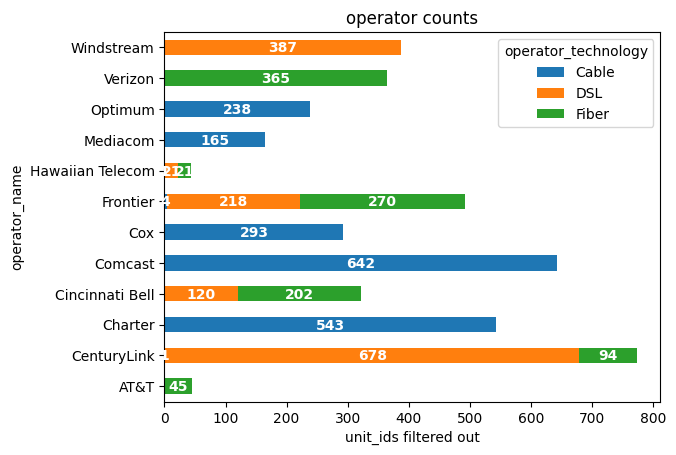

In [13]:
_ = get_operator_stats(data, tabulate=True)
plot_pivot_df(get_operator_stats(data, tabulate=False), title=(f"operator counts"))

### Applying all the filters

In [17]:
results = get_filter_counts(data)
print("The Filter counts are: ")
print(results.to_markdown(tablefmt="grid", floatfmt=".2f"))

print("\n\n\n\nThe cumulative filter counts are: ")
filter_list=["zeros", "rtt>300ms", "rtt_min<0.05ms", "delta_rtt>300ms", "packet_loss_10", "exclude_units"]
results, filtered_data, match_data = get_cumulative_filter_counts(data, filter_list=filter_list)
print(results.to_markdown(tablefmt="grid", floatfmt=".2f"))

The Filter counts are: 
+-------+----------------------+----------------+------------------------------+
|       | Filter applied       |   Filter Count |   Percentage of initial data |
+=======+======================+================+==============================+
| 0     | unit_id_zeros        |           0.00 |                         0.00 |
+-------+----------------------+----------------+------------------------------+
| 1     | dtime_empty          |           0.00 |                         0.00 |
+-------+----------------------+----------------+------------------------------+
| 2     | target_empty         |           0.00 |                         0.00 |
+-------+----------------------+----------------+------------------------------+
| 3     | rtt_avg_zeros        |        4071.00 |                         0.08 |
+-------+----------------------+----------------+------------------------------+
| 4     | rtt_min_zeros        |        4071.00 |                         0.08 |
+---

### Analysis of each individual filter

#### Filter:1a rtt_avg=0

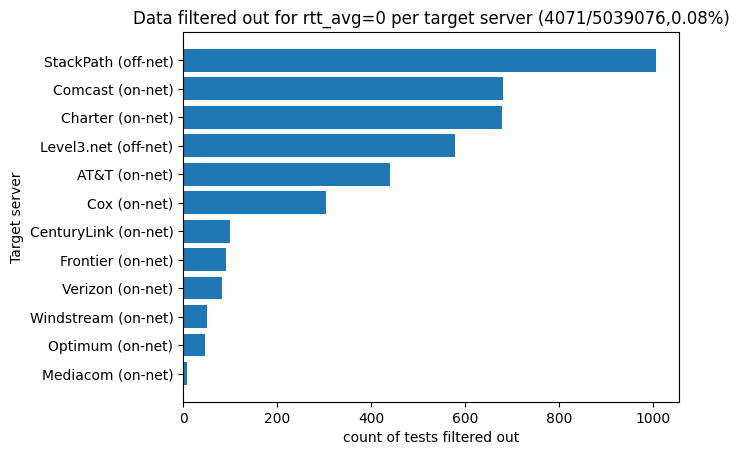

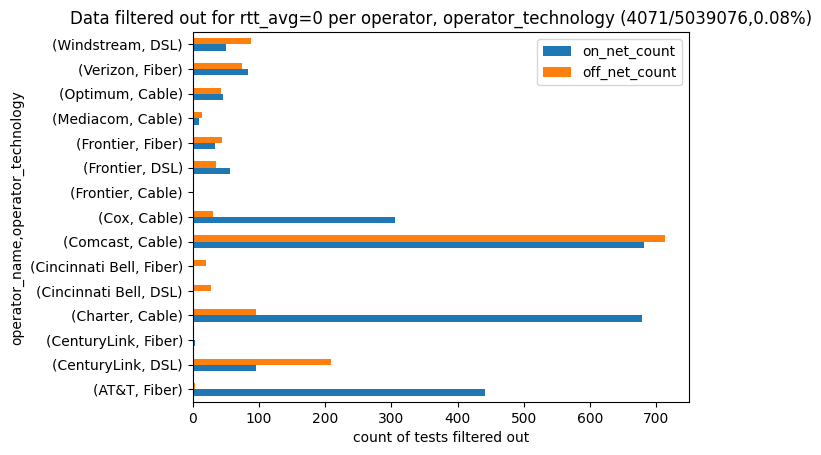

In [18]:
filter_list = ["zeros"]
ignore_list = ["rtt_std", "failures", "successes", "rtt_max", "rtt_min"]
match_data = analyze_filter(filter_list, "Data filtered out for rtt_avg=0", ignore_list=ignore_list, plot_pivot=False)

#### Filter 2: delta_rtt>300ms

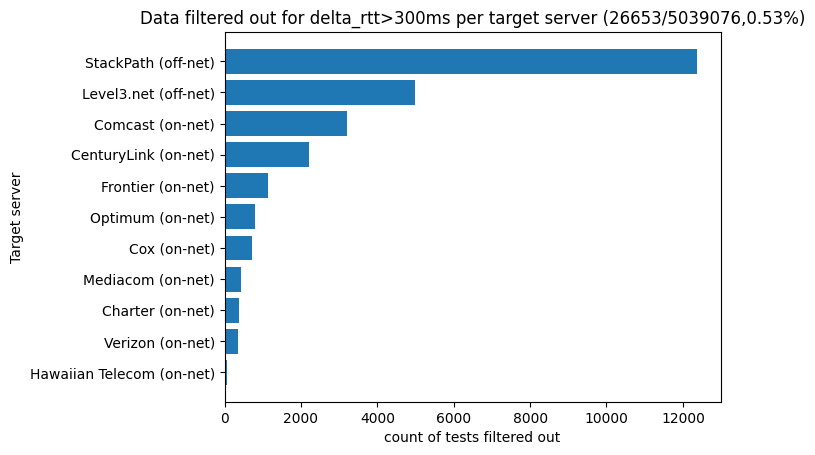

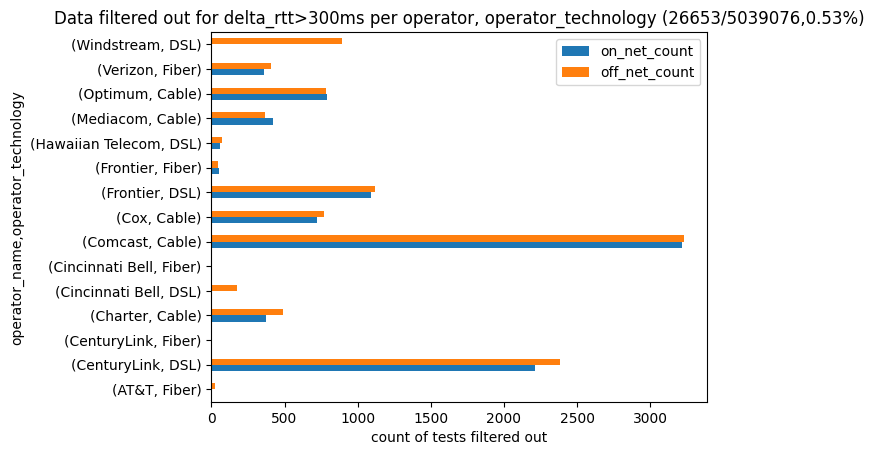

In [19]:
filter_list = ["zeros", "delta_rtt>300ms"]
match_data = analyze_filter(filter_list, "Data filtered out for delta_rtt>300ms")

#### Filter 5: packet_loss_10

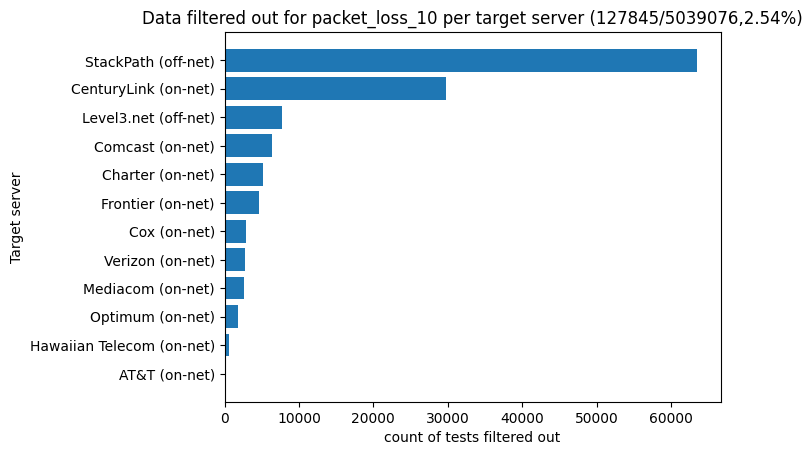

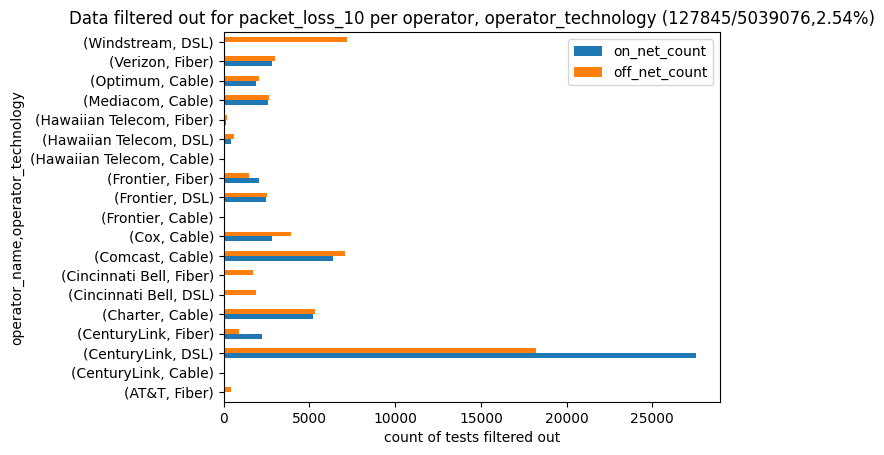

In [20]:
filter_list = ["zeros", "delta_rtt>300ms", "packet_loss_10"]
match_data = analyze_filter(filter_list, "Data filtered out for packet_loss_10")

#### Filter 6: excluded unit_ids

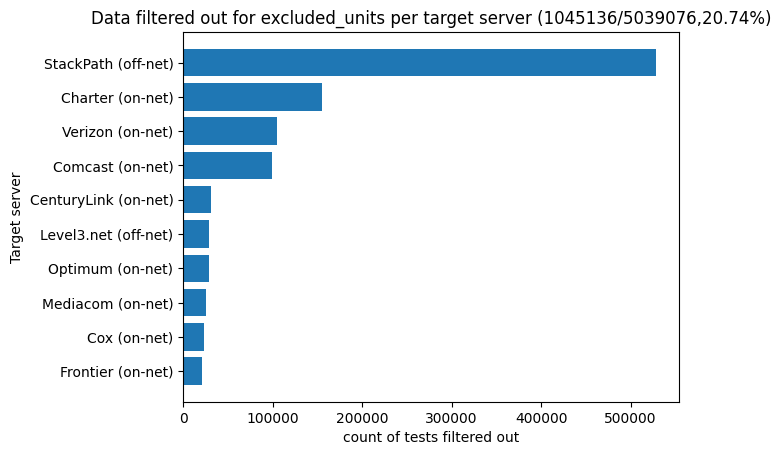

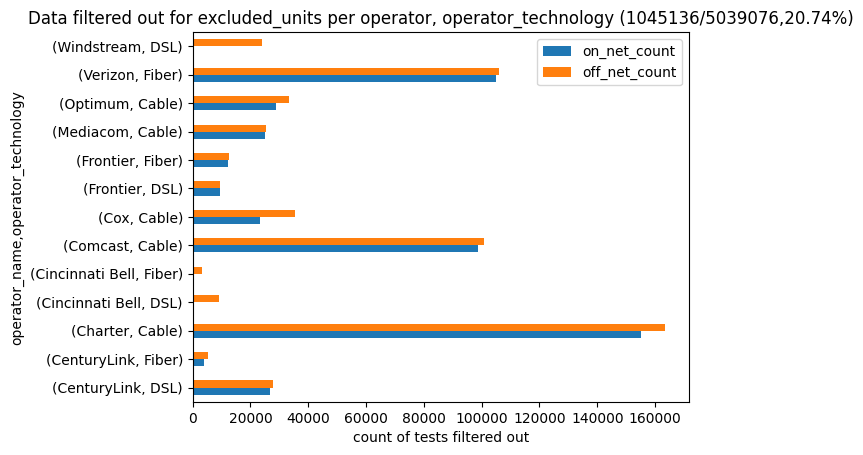

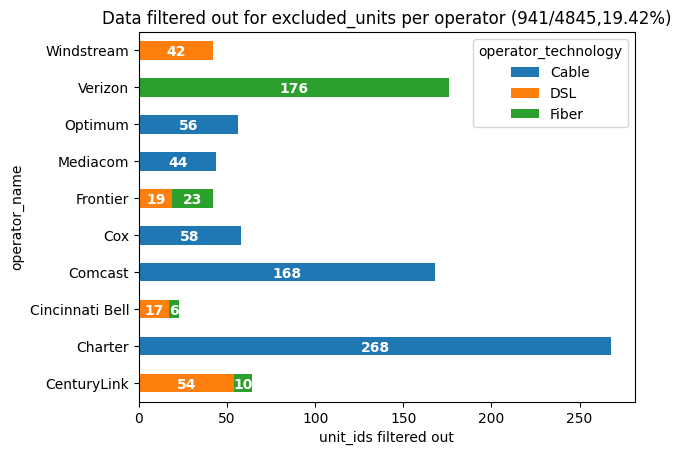

In [21]:
filter_list = ["zeros", "delta_rtt>300ms", "rtt_min<0.05ms", "packet_loss_10", "exclude_units"]
match_data = analyze_filter(filter_list, "Data filtered out for excluded_units", plot_pivot=True)

# Range of maximum latencies

In [27]:
def get_max_latency_range(curr_data, boundaries):
    filtering_results = []
    initial_count = curr_data.shape[0]
    # lower window
    filtered_indices = ((curr_data.rtt_max - curr_data.rtt_min) <= boundaries[0]*1000)
    filter_count = filtered_indices.sum()
    filtering_results.append([f"<={boundaries[0]}ms", filter_count, round((filter_count/initial_count)*100, 2)])
    for i in range(len(boundaries)-1):
        lower, upper = boundaries[i], boundaries[i+1]
        filtered_indices = (((curr_data.rtt_max - curr_data.rtt_min) > lower*1000) & ((curr_data.rtt_max - curr_data.rtt_min) <= upper*1000))
        filter_count = filtered_indices.sum()
        filtering_results.append([f"{lower}ms-{upper}ms", filtered_indices.sum(), round((filter_count/initial_count)*100, 2)])
    # upper window
    filtered_indices = ((curr_data.rtt_max - curr_data.rtt_min) > boundaries[-1]*1000)
    filter_count = filtered_indices.sum()
    filtering_results.append([f">={boundaries[-1]}ms", filtered_indices.sum(), round((filter_count/initial_count)*100, 2)])

    results = pd.DataFrame(filtering_results, columns=['Range', 'Count', 'Percentage'])
    # results.loc['Total'] = results[['Count', 'Percentage']].sum()
    # results = results.fillna('')
    return results

In [28]:
boundaries = [50,100,200,300,400,500,600,700,800,900]
_, filtered_data, _ = get_cumulative_filter_counts(data, filter_list=["zeros"])
results = get_max_latency_range(filtered_data, boundaries)
print("Range of delta_rtt (rtt_max-rtt_min)")
print(results.to_markdown(tablefmt="grid", floatfmt=""))

Range of delta_rtt (rtt_max-rtt_min)
+----+-------------+---------+--------------+
|    | Range       |   Count |   Percentage |
+====+=============+=========+==============+
|  0 | <=50ms      | 4899506 |        97.31 |
+----+-------------+---------+--------------+
|  1 | 50ms-100ms  |   57348 |         1.14 |
+----+-------------+---------+--------------+
|  2 | 100ms-200ms |   38979 |         0.77 |
+----+-------------+---------+--------------+
|  3 | 200ms-300ms |   12519 |         0.25 |
+----+-------------+---------+--------------+
|  4 | 300ms-400ms |    6203 |         0.12 |
+----+-------------+---------+--------------+
|  5 | 400ms-500ms |    5425 |         0.11 |
+----+-------------+---------+--------------+
|  6 | 500ms-600ms |    3513 |         0.07 |
+----+-------------+---------+--------------+
|  7 | 600ms-700ms |    1950 |         0.04 |
+----+-------------+---------+--------------+
|  8 | 700ms-800ms |    1459 |         0.03 |
+----+-------------+---------+-------------

[]

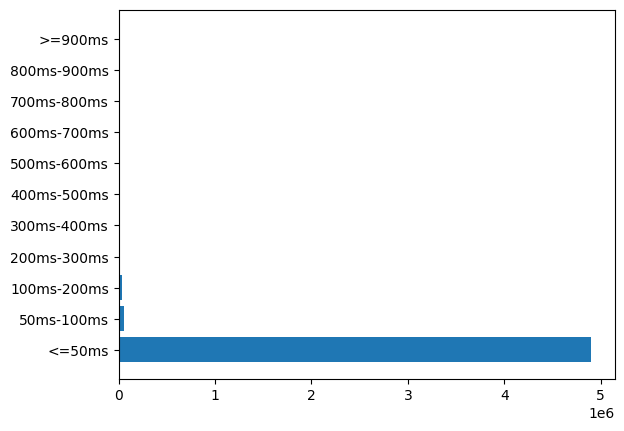

In [29]:
plt.barh(results["Range"], results["Count"])
plt.plot()

# Range of minimum latencies

In [30]:
def get_min_latency_range(curr_data, boundaries):
    filtering_results = []
    initial_count = curr_data.shape[0]
    # lower window
    filtered_indices = (curr_data.rtt_min <= boundaries[0]*1000)
    filter_count = filtered_indices.sum()
    filtering_results.append([f"<={boundaries[0]}ms", filter_count, round((filter_count/initial_count)*100, 2)])
    for i in range(len(boundaries)-1):
        lower, upper = boundaries[i], boundaries[i+1]
        filtered_indices = ((curr_data.rtt_min > lower*1000) & (curr_data.rtt_min <= upper*1000))
        filter_count = filtered_indices.sum()
        filtering_results.append([f"{lower}ms-{upper}ms", filtered_indices.sum(), round((filter_count/initial_count)*100, 2)])
    # upper window
    filtered_indices = (curr_data.rtt_min > boundaries[-1]*1000)
    filter_count = filtered_indices.sum()
    filtering_results.append([f">={boundaries[-1]}ms", filtered_indices.sum(), round((filter_count/initial_count)*100, 2)])

    results = pd.DataFrame(filtering_results, columns=['Range', 'Count', 'Percentage'])
    # results.loc['Total'] = results[['Count', 'Percentage']].sum()
    # results = results.fillna('')
    return results

In [31]:
boundaries = [0.05,0.25,0.5,0.75,1,5]
_, filtered_data, _ = get_cumulative_filter_counts(data, filter_list=["zeros"])
results = get_min_latency_range(filtered_data, boundaries)
print(results.to_markdown(tablefmt="grid", floatfmt=""))

+----+---------------+---------+--------------+
|    | Range         |   Count |   Percentage |
+====+===============+=========+==============+
|  0 | <=0.05ms      |       0 |         0.0  |
+----+---------------+---------+--------------+
|  1 | 0.05ms-0.25ms |       1 |         0.0  |
+----+---------------+---------+--------------+
|  2 | 0.25ms-0.5ms  |      43 |         0.0  |
+----+---------------+---------+--------------+
|  3 | 0.5ms-0.75ms  |     222 |         0.0  |
+----+---------------+---------+--------------+
|  4 | 0.75ms-1ms    |     390 |         0.01 |
+----+---------------+---------+--------------+
|  5 | 1ms-5ms       |  295921 |         5.88 |
+----+---------------+---------+--------------+
|  6 | >=5ms         | 4738428 |        94.11 |
+----+---------------+---------+--------------+


[]

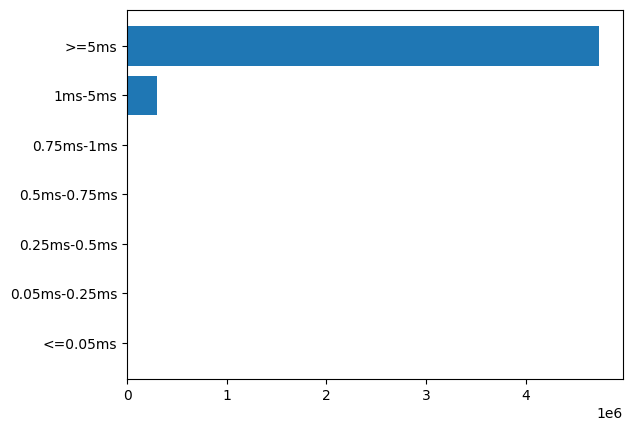

In [32]:
plt.barh(results["Range"], results["Count"])
plt.plot()